In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chisquare

In [2]:
yellow_2018_06=pd.read_csv('yellow_tripdata_2018-06.csv',encoding='latin1')

In [3]:
taxi_zones=pd.read_csv('taxi_zone_lookup.csv',encoding='latin1')

In [4]:
yellow_tz_2018_06 = yellow_2018_06.merge(taxi_zones,left_on='PULocationID', right_on='LocationID')

In [5]:
#Creation of boroughs column (type Series)
boroughs=yellow_tz_2018_06['Borough']

In [6]:
#Creation of payment_type column (type Series)
payments_type=yellow_tz_2018_06['payment_type']

In [7]:
dict_pay_id={1:'Credit Card', 2:'Cash', 3:'No charge', 4:'Dispute', 5:'Unknown', 6:'Voided trip'}

In [13]:
# Merge the two Series in one dataframe:
df_201806=pd.concat([boroughs,payments_type], axis=1)

In [14]:
# We changed the id of the payments with the real, human readable, name 
# In the dataframe we are using => df_201806 

In [15]:
df_201806['payment_type']=df_201806['payment_type'].apply(lambda x: dict_pay_id[x])

In [16]:
# We need to see in which way are used means for each borough

In [19]:
#obj2=df_201806.groupby(['payment_type']).count()  #print(obj.count()['payment_type']) same thing but different output of fieldname

In [16]:
#df_201806.set_index('boroughs', inplace=True)
#df_201806.groupby(['boroughs'])['payment_type'].count().plot(legend=True)


In [17]:
#df_201806['Borough'][0]

'Queens'

In [13]:
#try_df1=df_201806.head(100)

In [14]:
#try_df2=df_201806.tail(100)

In [15]:
#try_df=pd.concat([try_df1,try_df2])

In [18]:
def count_payments_per_borough(DF):
    d=dict()
    l=len(DF)
    
    for el in DF.iterrows():           #iterating rows through the dataframe
        if el[1][0] not in d.keys():   # if there still no Borough in the dict
            d[el[1][0]]=[[str(el[1][1]),1]]   # add Borough as key, setting the first list with the payment 
                                       # [payment_type, 1]     
        else:
            added=False
            lista=d[el[1][0]]
            for paymenttype_occurrences in lista:
                if paymenttype_occurrences[0] == str(el[1][1]):
                    paymenttype_occurrences[1]+=1
                    added=True
            if added==False:
                d[el[1][0]].append([el[1][1],1])                
           
    return d        

In [ ]:
official_df_201806_dict_for_plot=count_payments_per_borough(df_201806)

In [ ]:
def plot_dict(d):
    for key in d.keys():
        data_list=d[key]
        
        pay_types, values=zip(*data_list)
        
        fig, ax = plt.subplots(1)
        
        plt.bar(pay_types, values, color="orchid")
        ax.plot(pay_types,values, label=key)
        ax.set_title('%s', %key)
        
        plt.show()   

In [ ]:
plot_dict(official_df_201806_dict_for_plot)

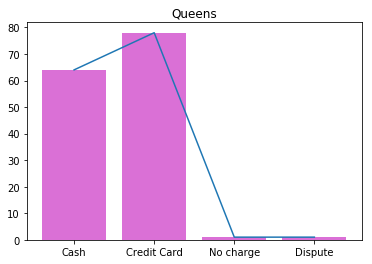

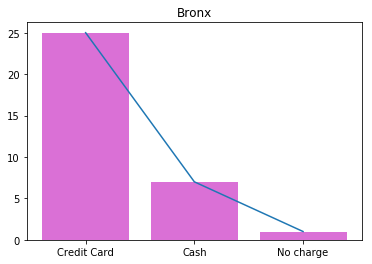

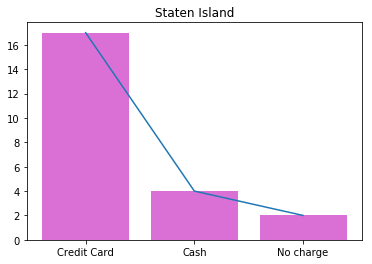

In [21]:
plot_dict(di)

In [ ]:
#######################ChiSquared Test############################

In [11]:
# for plot:
'''
  for key, data_list in data_dict.items():
    dates_str, values = zip(*data_list)  # Unpack
    dates = convert_str_to_dates(dates_str)  # Not handled in example
    plt.plot(dates, values, label=key)
plt.legend()  
'''

'\n  for key, data_list in data_dict.items():\n    dates_str, values = zip(*data_list)  # Unpack\n    dates = convert_str_to_dates(dates_str)  # Not handled in example\n    plt.plot(dates, values, label=key)\nplt.legend()  \n'

In [ ]:
#del yellow_2018_06
#del taxi_zones
#del yellow_tz_2018_06
#del df_201806
#del official_df_201806_dict_for_plot